In [22]:
import os
from data_loader import path_loader,FetchImage
from prostate_seg import *
import torch
# import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import MultiLabelMarginLoss,CrossEntropyLoss, BCELoss
import time
from tqdm import tqdm
from torchvision import transforms
from sklearn.model_selection import train_test_split
import config
import matplotlib.pyplot as plt
import argparse

In [23]:
print("Torch version: {}".format(torch.__version__))
print(torch.cuda.is_available())

Torch version: 1.10.1
True


#### Loading & Initializing variables

In [24]:
loader = path_loader()
loader.get_path(config.DATASET_MAIN_BRUNCH)
(im_path, mask_path) = loader.load_path()
DEVICE = config.DEVICE
THRESHOLD = config.THRESHOLD
split = train_test_split(im_path,mask_path,test_size=config.TEST_SPLIT,random_state = config.RAND_STATE)

total number of images for dicom and mask: 4104

The # of training batch: 2749

In [25]:
train_paths_Images,test_paths_Images,train_paths_Masks,test_paths_Masks = split[0],split[1],split[2],split[3]
trans = transforms.Compose([transforms.ToPILImage(),
                            transforms.ToTensor()])
_train = FetchImage(train_paths_Images,train_paths_Masks,trans)
_test = FetchImage(test_paths_Images, test_paths_Masks, trans)
train_Loader = DataLoader(_train,shuffle = True, batch_size = config.BATCH_SIZE,
                          pin_memory = config.PIN_MEMORY,num_workers = 4)
test_Loader = DataLoader(_test, shuffle=True, batch_size=config.BATCH_SIZE,
                          pin_memory=config.PIN_MEMORY,num_workers = 4)
unet = U_net().to(DEVICE)
lossFunc = BCELoss()
opt = Adam(unet.parameters(), lr=config.INIT_LR)
trainSteps = len(train_paths_Images) // config.BATCH_SIZE
testSteps = len(test_paths_Images) // config.BATCH_SIZE

In [5]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  485888 B  |  485888 B  |  485888 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |  485888 B  |  485888 B  |  485888 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |  485888 B  |  485888 B  |  485888 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [7]:
import torch
torch.cuda.empty_cache()

In [8]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  347993 KB |    1773 MB |   49471 MB |   49132 MB |
|       from large pool |  346112 KB |    1772 MB |   49433 MB |   49095 MB |
|       from small pool |    1881 KB |       2 MB |      38 MB |      36 MB |
|---------------------------------------------------------------------------|
| Active memory         |  347993 KB |    1773 MB |   49471 MB |   49132 MB |
|       from large pool |  346112 KB |    1772 MB |   49433 MB |

In [11]:
print(torch.cuda.memory_reserved())

2097152


In [12]:
torch.cuda.empty_cache()

In [26]:
H = {"train_loss": [], "test_loss": []}
startTime = time.time()

for e in tqdm(range(config.NUM_EPOCHS)):
    torch.cuda.empty_cache()
    unet.train()

    totalTrainLoss, totalTestLoss = 0, 0

    for (i,(x,y)) in enumerate(train_Loader):
        print(x.shape)
        print(y.shape)
        (x,y) = (x.to(DEVICE), y.to(DEVICE).long())
#         y = torch.squeeze(y,dim = 1)
#         pred = unet(x)
#         loss = lossFunc(pred,y)

#         opt.zero_grad()
#         #loss.requires_grad = True
#         loss.backward()
#         opt.step()

#         totalTrainLoss += lossFunc(pred,y)

#     ## switch off autograd
#     with torch.no_grad():

#         ## set the model in evaluation mode
#         unet.eval()

#         ## loop over the validation set
#         for (x,y) in test_Loader:
#             (x,y) = (x.to(DEVICE), y.to(DEVICE).long())
#             y = torch.squeeze(y, dim=1)
#             pred = unet(x)
#             #pred = torch.argmax(pred, dim=1)
#             totalTestLoss += lossFunc(pred,y)

#     avgTrainLoss = totalTrainLoss / trainSteps
#     avgTestLoss = totalTestLoss / testSteps

#     #print(avgTrainLoss)
#     #print(avgTestLoss)
#     H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
#     H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
#     print()
#     print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))
#     print("Train loss: {:.6f}, Test loss: {:.4f}".format(avgTrainLoss, avgTestLoss))
#     torch.cuda.empty_cache()
# # display the total time needed to perform the training
# endTime = time.time()
# print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

  0%|                                                                                           | 0/40 [00:05<?, ?it/s]


RuntimeError: DataLoader worker (pid(s) 7704, 24072, 35340, 34744) exited unexpectedly

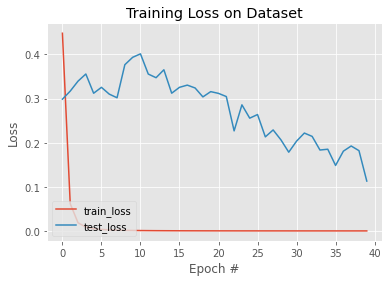

In [25]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(config.PLOT_PATH)
torch.save(unet, config.MODEL_PATH)

In [26]:
import pydicom
import cv2

In [31]:
test_img = 'DATASET/Prostatex-0026/t2_tse_tra/IM-0110-0008.dcm'
test_mask = 'DATASET/Prostatex-0026/mask/IM-0110-0008.png'

In [32]:
img_1 = pydicom.dcmread(test_img).pixel_array
img_uint8 = cv2.convertScaleAbs(img_1, alpha=(255.0 / 65535.0))

t = transforms.Compose([transforms.ToPILImage(),
                          transforms.ToTensor()])

_input = t(img_uint8)
_input = _input.unsqueeze(1)
print(_input.shape)
#__input = torch.squeeze(_input,dim = 1)
__input = _input.to('cpu')

torch.Size([1, 1, 384, 384])


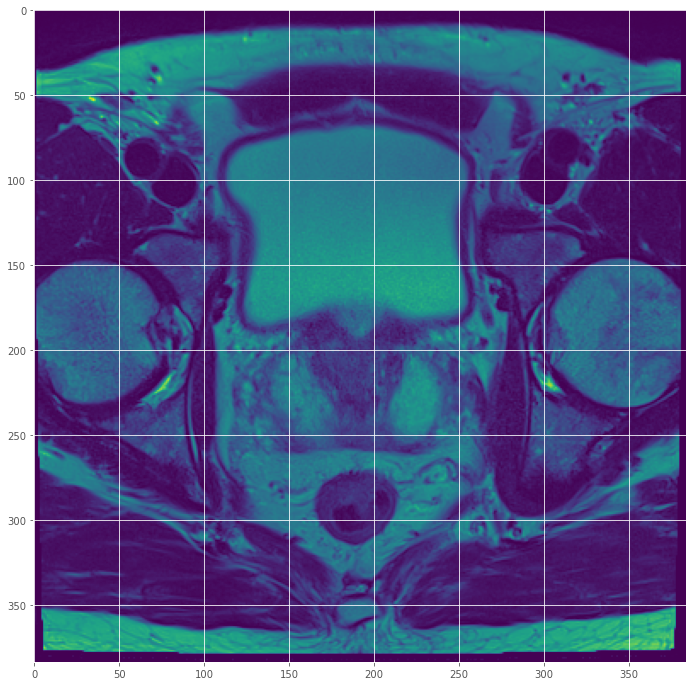

In [33]:
img_1 = pydicom.dcmread(test).pixel_array
plt.figure(figsize=(15, 12))
plt.imshow(img_1)
plt.show()

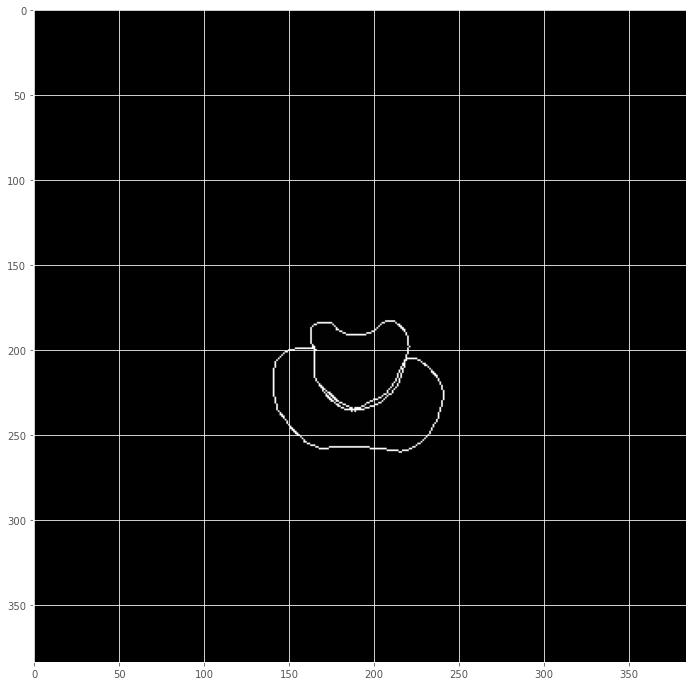

In [36]:
gt = cv2.imread(test_mask,0)
plt.figure(figsize=(15, 12))
plt.imshow(gt,cmap= 'gray')
plt.show()

In [37]:
img_Loader = DataLoader(__input, batch_size = 1,
                          pin_memory = config.PIN_MEMORY,num_workers = 4)

In [39]:
unet.eval()
for a,b in enumerate(img_Loader):
    with torch.no_grad():
        pred = unet(b)

In [87]:
p.shape

(1, 3, 384, 384)

In [48]:
m = nn.Softmax(dim=3)
pred_softmax = m(pred)

In [49]:
p = pred.numpy()
p_softmax = pred_softmax.numpy()

In [61]:
np.argmax(p_softmax, axis=1)

array([[[0, 0, 1, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 2],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 2, 2],
        [0, 0, 0, ..., 0, 2, 2],
        [0, 2, 0, ..., 0, 1, 2]]], dtype=int64)

In [65]:
print(p[0][0])
print(p[0][1])
print(p[0][2])

[[3.427073  2.5147583 2.4723196 ... 2.5300128 2.4687028 2.7751074]
 [2.1522915 1.6912432 1.6777487 ... 1.5852071 1.6216408 1.3350537]
 [2.1378367 1.7024808 1.6503236 ... 1.6537951 1.5102705 1.4014422]
 ...
 [2.3378327 1.8340403 1.9715198 ... 1.8007326 1.7758635 1.4312774]
 [2.2443204 1.8625429 1.8910146 ... 1.840791  1.7347252 1.4516717]
 [3.0010953 2.0253935 2.201111  ... 2.082071  2.0724223 1.9325806]]
[[-2.763333  -2.3000104 -2.107479  ... -2.3869054 -2.088016  -2.7590404]
 [-1.7373614 -1.3221686 -1.5557812 ... -1.2356968 -1.3713454 -1.1925894]
 [-1.6353129 -1.5091981 -1.3835638 ... -1.417938  -1.1476982 -1.4663115]
 ...
 [-1.916615  -1.5369705 -1.7597464 ... -1.4883975 -1.4570596 -1.2515157]
 [-1.7269063 -1.541657  -1.647081  ... -1.497457  -1.3916632 -1.4018463]
 [-2.0413227 -1.6678197 -1.7863516 ... -1.6659218 -1.59601   -2.1451094]]
[[-3.5025845 -2.9559581 -2.806297  ... -3.0300205 -2.7544448 -3.3363943]
 [-2.3896863 -2.1040273 -2.3588479 ... -1.9959886 -2.1215951 -1.7021598]
 [

In [66]:
print(p_softmax[0][0])
print(p_softmax[0][1])
print(p_softmax[0][2])

[[0.00691836 0.00277837 0.00266292 ... 0.00282108 0.00265331 0.00360461]
 [0.00505228 0.00318608 0.00314337 ... 0.00286553 0.00297186 0.00223134]
 [0.00520745 0.0033694  0.00319817 ... 0.00320929 0.00278021 0.00249352]
 ...
 [0.00443059 0.00267711 0.00307166 ... 0.00258942 0.00252581 0.00178957]
 [0.00411908 0.00281188 0.00289309 ... 0.00275138 0.00247449 0.00186448]
 [0.00650542 0.00245207 0.00292312 ... 0.00259507 0.00257015 0.00223473]]
[[0.00141348 0.00224651 0.00272347 ... 0.00205954 0.002777   0.00141956]
 [0.0015027  0.00227609 0.00180191 ... 0.00248167 0.00216687 0.00259099]
 [0.00158228 0.00179496 0.00203525 ... 0.00196647 0.00257663 0.00187361]
 ...
 [0.00171464 0.00250639 0.00200585 ... 0.00263114 0.0027149  0.00333442]
 [0.0019451  0.00234096 0.00210673 ... 0.00244675 0.00271979 0.00269223]
 [0.00174107 0.00252945 0.00224672 ... 0.00253426 0.00271777 0.00156943]]
[[0.00126911 0.00219228 0.00254621 ... 0.00203579 0.00268172 0.00149857]
 [0.00156021 0.00207607 0.00160907 ... 

In [86]:
np.argmax(p_softmax, axis=1)

array([[[0, 0, 1, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 2],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 2, 2],
        [0, 0, 0, ..., 0, 2, 2],
        [0, 2, 0, ..., 0, 1, 2]]], dtype=int64)

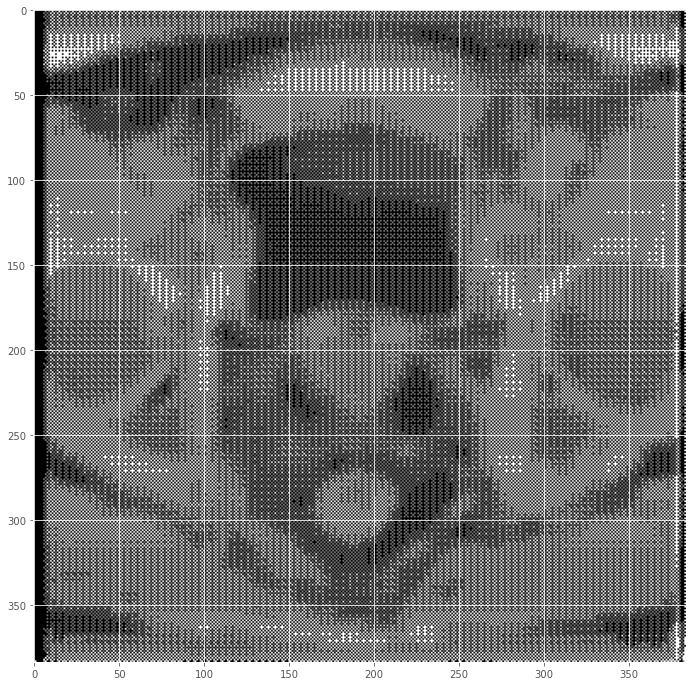

In [60]:
## experiment 1

plt.figure(figsize=(15, 12))
plt.imshow(np.argmax(p_softmax, axis=1).reshape(384,384),cmap= 'gray')
plt.show()

In [74]:
loader = path_loader()
loader.get_path(config.DATASET_MAIN_BRUNCH)
(im_path, mask_path) = loader.load_path()
DEVICE = config.DEVICE
THRESHOLD = config.THRESHOLD
imagePaths = sorted(list(im_path))[:1500]
maskPaths = sorted(list(mask_path))[:1500]
split = train_test_split(imagePaths,maskPaths,test_size=config.TEST_SPLIT,random_state = config.RAND_STATE)

In [76]:
DEVICE = 'cpu'

In [77]:
train_paths_Images,test_paths_Images,train_paths_Masks,test_paths_Masks = split[0],split[1],split[2],split[3]
trans = transforms.Compose([transforms.ToPILImage(),
                                 transforms.ToTensor()])
_train = FetchImage(train_paths_Images,train_paths_Masks,trans)
_test = FetchImage(test_paths_Images, test_paths_Masks, trans)
train_Loader = DataLoader(_train,shuffle = True, batch_size = config.BATCH_SIZE,
                          pin_memory = config.PIN_MEMORY,num_workers = 4)
test_Loader = DataLoader(_test, shuffle=True, batch_size=config.BATCH_SIZE,
                          pin_memory=config.PIN_MEMORY,num_workers = 4)
unet2 = U_net().to(DEVICE)
lossFunc = CrossEntropyLoss()
opt = Adam(unet2.parameters(), lr=0.0001)
trainSteps = len(train_paths_Images) // config.BATCH_SIZE
testSteps = len(test_paths_Images) // config.BATCH_SIZE

In [78]:
H = {"train_loss": [], "test_loss": []}
startTime = time.time()

for e in tqdm(range(config.NUM_EPOCHS)):
    #torch.cuda.empty_cache()
    unet2.train()

    totalTrainLoss, totalTestLoss = 0, 0

    for (i,(x,y)) in enumerate(train_Loader):

        (x,y) = (x.to(DEVICE), y.to(DEVICE).long())
        y = torch.squeeze(y,dim = 1)
        pred = unet2(x)
        loss = lossFunc(pred,y)

        opt.zero_grad()
        #loss.requires_grad = True
        loss.backward()
        opt.step()

        totalTrainLoss += lossFunc(pred,y)

    ## switch off autograd
    with torch.no_grad():

        ## set the model in evaluation mode
        unet2.eval()

        ## loop over the validation set
        for (x,y) in test_Loader:
            (x,y) = (x.to(DEVICE), y.to(DEVICE).long())
            y = torch.squeeze(y, dim=1)
            pred = unet2(x)
            #pred = torch.argmax(pred, dim=1)
            totalTestLoss += lossFunc(pred,y)

    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps

    #print(avgTrainLoss)
    #print(avgTestLoss)
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    print()
    print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(avgTrainLoss, avgTestLoss))
    
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

  2%|████▎                                                                                                                                                                     | 1/40 [06:22<4:08:34, 382.41s/it]


[INFO] EPOCH: 1/40
Train loss: 0.542934, Test loss: 0.6534


  5%|████████▌                                                                                                                                                                 | 2/40 [12:43<4:01:47, 381.78s/it]


[INFO] EPOCH: 2/40
Train loss: 0.288216, Test loss: 0.3597


  8%|████████████▊                                                                                                                                                             | 3/40 [18:57<3:53:10, 378.12s/it]


[INFO] EPOCH: 3/40
Train loss: 0.153997, Test loss: 0.2332


 10%|█████████████████                                                                                                                                                         | 4/40 [25:12<3:46:02, 376.73s/it]


[INFO] EPOCH: 4/40
Train loss: 0.086503, Test loss: 0.1568


 12%|█████████████████████▎                                                                                                                                                    | 5/40 [31:19<3:37:49, 373.42s/it]


[INFO] EPOCH: 5/40
Train loss: 0.052060, Test loss: 0.0959


 15%|█████████████████████████▌                                                                                                                                                | 6/40 [37:31<3:31:17, 372.88s/it]


[INFO] EPOCH: 6/40
Train loss: 0.033083, Test loss: 0.0656


 18%|█████████████████████████████▋                                                                                                                                            | 7/40 [43:40<3:24:24, 371.67s/it]


[INFO] EPOCH: 7/40
Train loss: 0.021931, Test loss: 0.0466


 20%|██████████████████████████████████                                                                                                                                        | 8/40 [49:49<3:17:43, 370.72s/it]


[INFO] EPOCH: 8/40
Train loss: 0.014966, Test loss: 0.0351


 22%|██████████████████████████████████████▎                                                                                                                                   | 9/40 [56:02<3:11:55, 371.47s/it]


[INFO] EPOCH: 9/40
Train loss: 0.010453, Test loss: 0.0265


 25%|█████████████████████████████████████████▊                                                                                                                             | 10/40 [1:02:10<3:05:10, 370.34s/it]


[INFO] EPOCH: 10/40
Train loss: 0.007421, Test loss: 0.0222


 28%|█████████████████████████████████████████████▉                                                                                                                         | 11/40 [1:08:27<3:00:00, 372.42s/it]


[INFO] EPOCH: 11/40
Train loss: 0.005326, Test loss: 0.0204


 30%|██████████████████████████████████████████████████                                                                                                                     | 12/40 [1:14:34<2:53:02, 370.80s/it]


[INFO] EPOCH: 12/40
Train loss: 0.003814, Test loss: 0.0192


 32%|██████████████████████████████████████████████████████▎                                                                                                                | 13/40 [1:20:47<2:47:12, 371.58s/it]


[INFO] EPOCH: 13/40
Train loss: 0.002776, Test loss: 0.0159


 35%|██████████████████████████████████████████████████████████▍                                                                                                            | 14/40 [1:27:02<2:41:26, 372.55s/it]


[INFO] EPOCH: 14/40
Train loss: 0.002044, Test loss: 0.0131


 38%|██████████████████████████████████████████████████████████████▋                                                                                                        | 15/40 [1:33:13<2:35:01, 372.08s/it]


[INFO] EPOCH: 15/40
Train loss: 0.001515, Test loss: 0.0110


 40%|██████████████████████████████████████████████████████████████████▊                                                                                                    | 16/40 [1:39:28<2:29:07, 372.80s/it]


[INFO] EPOCH: 16/40
Train loss: 0.001128, Test loss: 0.0087


 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                | 17/40 [1:45:38<2:22:39, 372.16s/it]


[INFO] EPOCH: 17/40
Train loss: 0.000843, Test loss: 0.0072


 45%|███████████████████████████████████████████████████████████████████████████▏                                                                                           | 18/40 [1:51:49<2:16:15, 371.63s/it]


[INFO] EPOCH: 18/40
Train loss: 0.000631, Test loss: 0.0063


 48%|███████████████████████████████████████████████████████████████████████████████▎                                                                                       | 19/40 [1:58:00<2:10:02, 371.55s/it]


[INFO] EPOCH: 19/40
Train loss: 0.000474, Test loss: 0.0055


 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 20/40 [2:04:09<2:03:37, 370.89s/it]


[INFO] EPOCH: 20/40
Train loss: 0.000357, Test loss: 0.0050


 52%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 21/40 [2:10:25<1:57:56, 372.42s/it]


[INFO] EPOCH: 21/40
Train loss: 0.000270, Test loss: 0.0039


 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 22/40 [2:16:37<1:51:37, 372.09s/it]


[INFO] EPOCH: 22/40
Train loss: 0.000204, Test loss: 0.0033


 57%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 23/40 [2:22:52<1:45:42, 373.11s/it]


[INFO] EPOCH: 23/40
Train loss: 0.000155, Test loss: 0.0026


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 24/40 [2:29:05<1:39:29, 373.11s/it]


[INFO] EPOCH: 24/40
Train loss: 0.000117, Test loss: 0.0022


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 25/40 [2:35:14<1:32:54, 371.65s/it]


[INFO] EPOCH: 25/40
Train loss: 0.000089, Test loss: 0.0020


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 26/40 [2:41:27<1:26:51, 372.27s/it]


[INFO] EPOCH: 26/40
Train loss: 0.000068, Test loss: 0.0017


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 27/40 [2:47:36<1:20:25, 371.18s/it]


[INFO] EPOCH: 27/40
Train loss: 0.000052, Test loss: 0.0013


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 28/40 [2:53:49<1:14:21, 371.79s/it]


[INFO] EPOCH: 28/40
Train loss: 0.000039, Test loss: 0.0010


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 29/40 [2:59:56<1:07:52, 370.24s/it]


[INFO] EPOCH: 29/40
Train loss: 0.000030, Test loss: 0.0008


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 30/40 [3:06:04<1:01:35, 369.51s/it]


[INFO] EPOCH: 30/40
Train loss: 0.000023, Test loss: 0.0005


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 31/40 [3:12:19<55:41, 371.32s/it]


[INFO] EPOCH: 31/40
Train loss: 0.000017, Test loss: 0.0003


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 32/40 [3:18:30<49:29, 371.19s/it]


[INFO] EPOCH: 32/40
Train loss: 0.000013, Test loss: 0.0002


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 33/40 [3:24:45<43:26, 372.39s/it]


[INFO] EPOCH: 33/40
Train loss: 0.000010, Test loss: 0.0002


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 34/40 [3:30:52<37:04, 370.81s/it]


[INFO] EPOCH: 34/40
Train loss: 0.000007, Test loss: 0.0001


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 35/40 [3:37:00<30:49, 369.98s/it]


[INFO] EPOCH: 35/40
Train loss: 0.000006, Test loss: 0.0001


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 36/40 [3:43:13<24:43, 370.76s/it]


[INFO] EPOCH: 36/40
Train loss: 0.000004, Test loss: 0.0001


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 37/40 [3:49:20<18:29, 369.78s/it]


[INFO] EPOCH: 37/40
Train loss: 0.000003, Test loss: 0.0001


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 38/40 [3:55:34<12:22, 371.02s/it]


[INFO] EPOCH: 38/40
Train loss: 0.000003, Test loss: 0.0001


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 39/40 [4:01:41<06:09, 369.77s/it]


[INFO] EPOCH: 39/40
Train loss: 0.000002, Test loss: 0.0000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [4:07:51<00:00, 371.79s/it]


[INFO] EPOCH: 40/40
Train loss: 0.000001, Test loss: 0.0000
[INFO] total time taken to train the model: 14871.50s


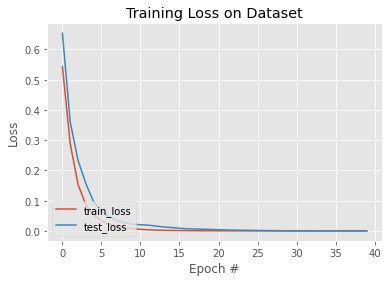

In [79]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(config.PLOT_PATH)
torch.save(unet, config.MODEL_PATH)

In [80]:
unet.eval()
for a,b in enumerate(img_Loader):
    with torch.no_grad():
        pred2 = unet2(b)

In [81]:
m = nn.Softmax(dim=3)
pred2_softmax = m(pred2)

In [82]:
p2 = pred2.numpy()
p2_softmax = pred2_softmax.numpy()

In [83]:
np.argmax(p2_softmax, axis=1)

array([[[0, 2, 0, ..., 1, 1, 2],
        [1, 2, 0, ..., 1, 2, 2],
        [1, 2, 0, ..., 2, 1, 2],
        ...,
        [1, 1, 2, ..., 0, 2, 1],
        [1, 2, 1, ..., 1, 1, 2],
        [1, 1, 2, ..., 0, 2, 0]]], dtype=int64)

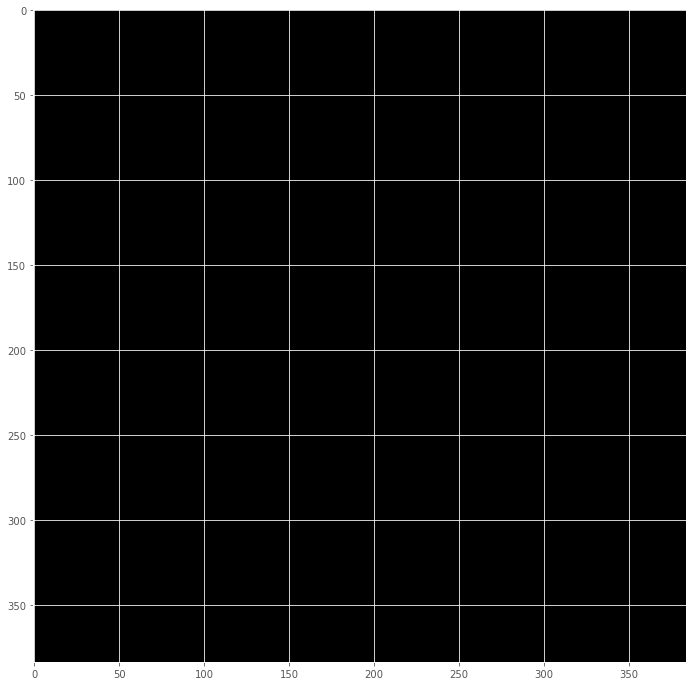

In [85]:
plt.figure(figsize=(15, 12))
plt.imshow(np.argmax(p2, axis=1).reshape(384,384),cmap= 'gray')
plt.show()

In [ ]:
## 1. increase the batch size -> check the image size
## 2. data linkdage -> do cross validation on images on per patience 